In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import repeat
from metrics import root_mean_squared_error, mean_absolute_percentage_error
from preprocessor import Preprocessor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR

sns.set(font_scale=1.5)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PATH_APERIODIC = '/content/drive/My Drive/HobbyTaste/data/nasdaq100_padding.csv'

In [0]:
nasdaq_df = pd.read_csv(DATA_PATH_APERIODIC)
D_size = 10

In [0]:
nasdaq_preproc_data = Preprocessor(
    data=nasdaq_df.iloc[:40000, :].values,
    D_size=D_size
)

100%|██████████| 969/969 [00:00<00:00, 4449.48it/s]


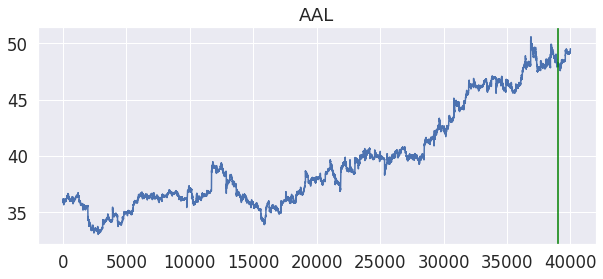

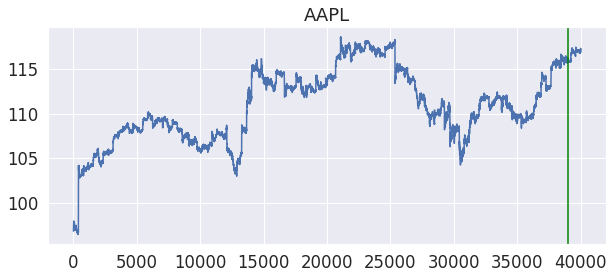

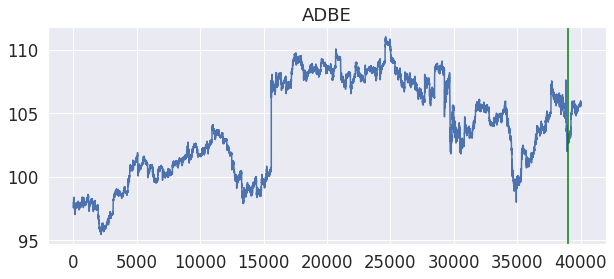

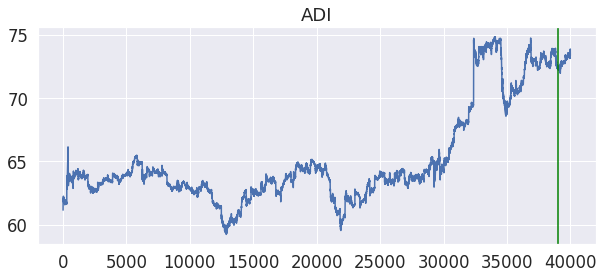

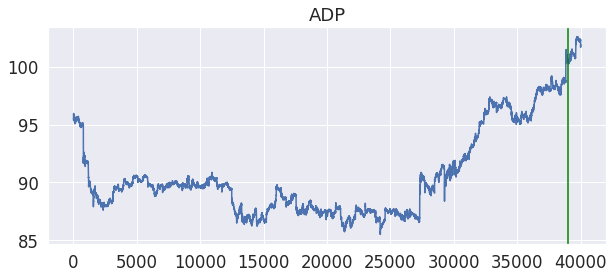

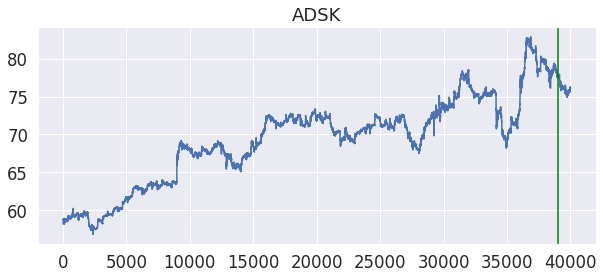

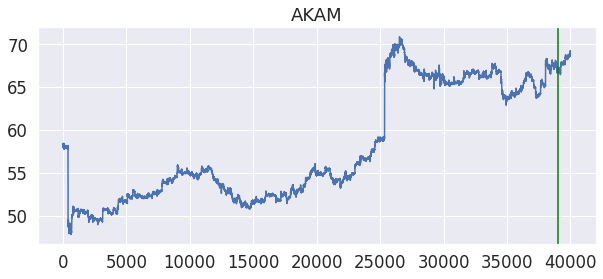

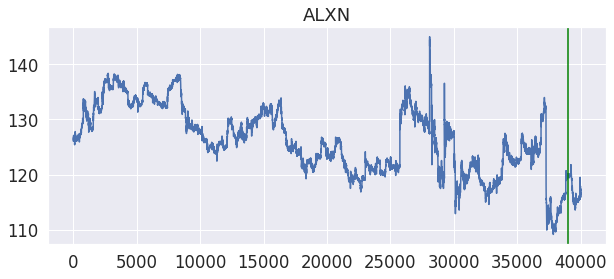

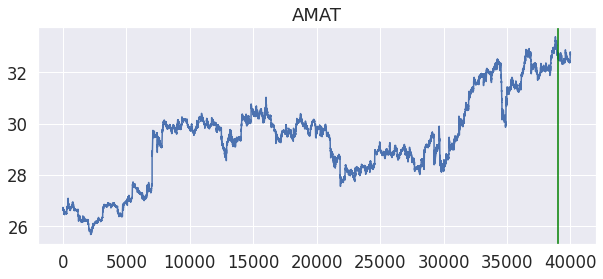

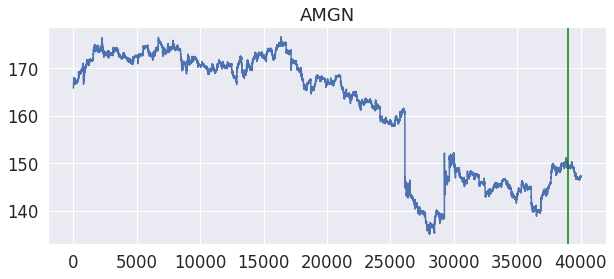

In [6]:
nasdaq_preproc_data.train_test_split(train_size=39000)
nasdaq_preproc_data.plot_data(titles=nasdaq_df.columns[:D_size])

In [0]:
scaler = MinMaxScaler()

Для разных рамерностей данных попробуем разные горизонты обучения/прогнозирования. Посчитаем MAPE на тестовой выборке на pred_horizon элементах для каждой компоненты временного ряда, усредним и затем сложим все D_size результатов.

In [0]:
D_size_list = [3, 5, 7, 10]
prediction_horizons = [3, 6, 12, 24]
train_horizons = [3, 6, 12, 21, 30]

In [9]:

for D in D_size_list:
    test = nasdaq_preproc_data.test_data[:, :D]
    results = {}
    for p in train_horizons:
        model = VAR(
            scaler.fit_transform(nasdaq_preproc_data.train_data[:, :D])
        ).fit(p)
        results[p] = {}
        for pred_horizon in prediction_horizons:
            mape = []
            for i in np.arange(0, len(test) - p - pred_horizon, pred_horizon):
                pred = model.forecast(test[i:i+p], 
                                      steps=pred_horizon)
                mape_component = []
                for comp in np.arange(D):
                    mape_component.append(
                        mean_absolute_percentage_error(
                            test[i+p:i+p+pred_horizon][:, comp],
                            pred[:, comp]
                        )
                    )
                mape.append(
                    np.sum(
                        mape_component
                    )
                )
            results[p][pred_horizon] = np.mean(mape)
    df = pd.DataFrame(results)
    columns= list(zip(repeat('train horizon'), df.columns))

    df.columns=pd.MultiIndex.from_tuples(columns)
    df.index.name='prediction horizon'
    print('='*48)
    print("D_size: {}, MAPE".format(D))
    print(df)
    print('='*48)

D_size: 3, MAPE
                   train horizon                                        
                              3         6         12        21        30
prediction horizon                                                      
3                       0.186727  0.185415  0.184201  0.183995  0.184810
6                       0.265413  0.269077  0.266411  0.259152  0.267579
12                      0.432386  0.402523  0.420558  0.393905  0.400959
24                      0.695107  0.675685  0.705255  0.631812  0.662183
D_size: 5, MAPE
                   train horizon                                        
                              3         6         12        21        30
prediction horizon                                                      
3                       0.372897  0.370242  0.362298  0.364832  0.363382
6                       0.585308  0.580218  0.564296  0.562945  0.569591
12                      1.015280  0.976901  0.940819  0.944026  0.946657
24                 

Итак, я попробовал разные значения D_size и горизонтов обучения/предсказания. Как и ожидалось, использование слишком маленького горизонта для обучения увеличивает ошибку при долгосрочном прогнозе. При этом так же надо отметить, что и размерность временного ряда играет важную роль: так, например, для D_size равным 10 MAPE оказывается в несколько раз больше чем для 7; слишком большое значение D_size приведет скорее всего к значительной ошибке, а значит стоит этого избегать.